# Author

### Md Fahim Hasan
#### PhD Candidate
#### Civil and Environmental Engineering
#### Colorado State University

--------------

In [1]:
from SWB_utils import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

-----------

# SWB model run

## Step 1: Assign crop growth stages

In [2]:
input_file = '../input_data.csv'  # Path to your input CSV data

emergence_day = '15-May-2005'
full_canopy_day = '09-Jul-2005'
Lin = 20  # Length of initial growth stage (source: Table 8.3-Hoffman 2007)
Lmid = 60  # Length of mid-season (source: Table 8.3-Hoffman 2007)

df1, Ldev_start_DOY, Ldev_end_DOY, Llate_start_DOY, Llate_end_DOY = decide_crop_growth_stage(
    input_csv_data=input_file, emergence_day=emergence_day, full_canopy_day=full_canopy_day, Lin=Lin, Lmid=Lmid)

## Step 2: Calculate root zone depth (Rz)

In [3]:
Rz_ini = 0.15  # Initial root zone depth in meters
Rz_max = 0.7  # Maximum root zone depth in meters

df2 = calc_Rz(df1, Rz_ini=Rz_ini, Rz_max=Rz_max, doy_col='DOY')

## Step 3: Calculate TAW, RAW, and dMAD

In [4]:
MAD_fraction = 0.5  # Value for allowable soil water depletion fraction
# source MAD data https://extension.umn.edu/irrigation/basics-irrigation-scheduling#table-4-recommended-allowable-soil-moisture-depletion-limits-for-crops-by-growth-stage-1847510

theta_fc_perc = 21.1  # Volumetric soil moisture at field capacity (%)
theta_wp_perc = 12.04  # Volumetric soil moisture at wilting point (%)

df3 = calc_TAW_RAW_dMAD(df2, MAD_fraction=MAD_fraction, theta_fc_perc=theta_fc_perc, theta_wp_perc=theta_wp_perc)

## Step 4: Estimate Kcb values for the entire season

In [5]:
Kcb_ini = 0.15  # Initial crop coefficient for soybeans (source: Table 8.2-Hoffman 2007)
Kcb_mid = 1.1  # Mid-season crop coefficient (source: Table 8.2-Hoffman 2007)
Kcb_end = 0.3  # End-season crop coefficient (source: Table 8.2-Hoffman 2007)
target_climate = 'sub-humid'

df4, Kcb_ini_mod, Kcb_mid_mod, Kcb_end_mod = estimate_Kcb_all_season(
    df3, Kcb_ini=Kcb_ini, Kcb_mid=Kcb_mid, Kcb_end=Kcb_end,
    Ldev_start_DOY=Ldev_start_DOY, Ldev_end_DOY=Ldev_end_DOY,
    Llate_start_DOY=Llate_start_DOY, Llate_end_DOY=Llate_end_DOY,
    target_climate=target_climate)

## Step 5: Estimate Kcmax values

In [6]:
df5 = estimate_Kcmax(df4, windS_col='U', minRH_col='RH min', canopyH_col='hc')

## Step 6: Assign TEW and REW values based on soil type

In [7]:
# Selected TEW and REW values on the higher ends of the prescribed ranges
# Ze considered 0.1 m as sandy loam is coarse soil
TEW = 12  # Total evaporable water in mm (source: Table 8.5-Hoffman 2007)
REW = 7  # Readily evaporable water in mm (source: Table 8.5-Hoffman 2007)

df6 = assign_TEW_REW(df5, TEW=TEW, REW=REW)

## Step 7: Estimate fraction of soil exposed and wetted (fc and few)

In [8]:
fw = 1  # considering Lateral Move (self-propelled) sprinkler (source: Table 8.6-Hoffman 2007)
df7 = estimate_few(df6, fw=fw, Kcmin=Kcb_ini_mod, canopyH_col='hc')

## Step 8: Curate and reorder Precipitation and Irrigation data

In [9]:
df8 = curate_reorder_P_Irr_data(df7, precip_col='Precip', Irr_col='Irr')

## Step 9: Run the daily water balance calculations

In [10]:
SWB_final_df = run_daily_water_balance(df8)

Running daily soil water balance...
Daily soil water balance run completed...


------------

# SWB model ouput plots

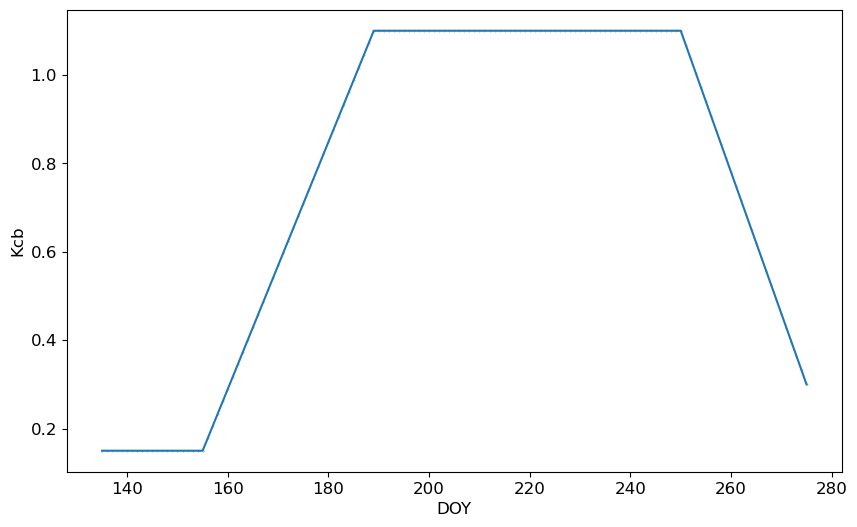

In [11]:
# Kcb vs DOY
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10, 6))
plt.plot(SWB_final_df['DOY'], SWB_final_df['Kcb_daily'], label='Kcb', marker='o', markersize=0.2)

plt.xlabel('DOY')
plt.ylabel('Kcb')
plt.savefig('./figs/Kcb.png')

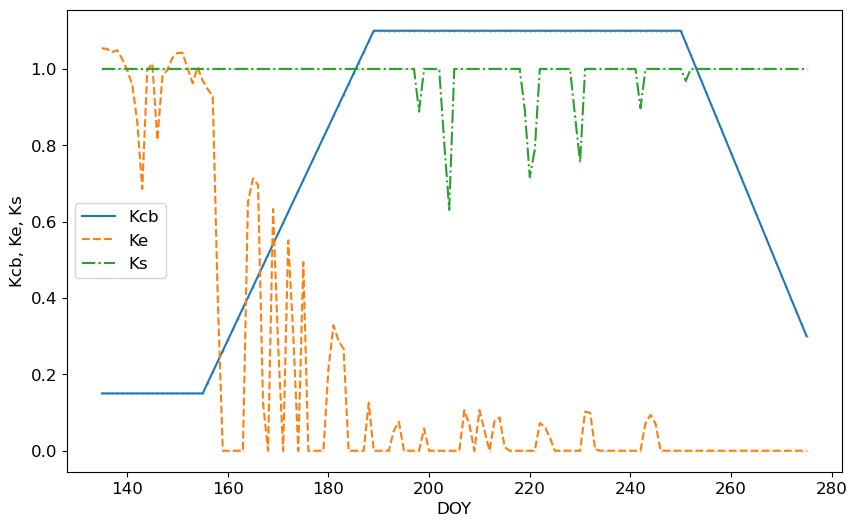

In [12]:
# Kcb, Ke, and Ks
plt.figure(figsize=(10, 6))

plt.plot(SWB_final_df['DOY'], SWB_final_df['Kcb_daily'], label='Kcb', marker='o', markersize=0.3)
plt.plot(SWB_final_df['DOY'], SWB_final_df['Ke'], label='Ke', marker='o', linestyle='--', markersize=0.2)
plt.plot(SWB_final_df['DOY'], SWB_final_df['Ks'], label='Ks', marker='o', linestyle='-.', markersize=0.2)

plt.xlabel('DOY')
plt.ylabel('Kcb, Ke, Ks')

plt.legend()
plt.savefig('./figs/all_coefs.png')

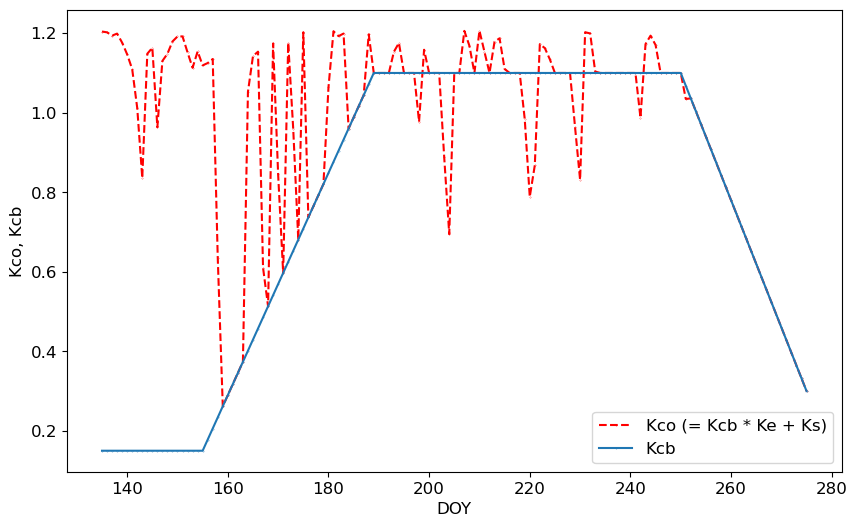

In [13]:
# Kco (Kcb*Ke + Ks) and Kcb
plt.figure(figsize=(10, 6))

plt.plot(SWB_final_df['DOY'], SWB_final_df['Kco'], label='Kco (= Kcb * Ke + Ks)', marker='o', markersize=0.2, linestyle='--', color='red')
plt.plot(SWB_final_df['DOY'], SWB_final_df['Kcb_daily'], label='Kcb', marker='o', markersize=0.2)

plt.xlabel('DOY')
plt.ylabel('Kco, Kcb')

plt.legend()
plt.savefig('./figs/Kcb_vs_Kco_comparison.png')

In [ ]:
# ETa and ETo 
plt.figure(figsize=(10, 6))

plt.plot(SWB_final_df['DOY'], SWB_final_df['ETa'], label='ETa', marker='^', markersize=0.2, color='green')
plt.plot(SWB_final_df['DOY'], SWB_final_df['ETo'], label='ETo', marker='s', markersize=0.2, color='blue')

plt.xlabel('DOY')
plt.ylabel('ET (mm/d)')

plt.legend()
plt.savefig('./figs/ETref_Eta.png')

In [ ]:
# SMD and dMAD

fig, ax1 = plt.subplots(figsize=(10, 6))

line1, = ax1.plot(SWB_final_df['DOY'], SWB_final_df['Di_start'], label='SMD', color='red')
ax1.set_xlabel('DOY')
ax1.set_ylabel('Soil Moisture Depletion (mm)', color='red')
ax1.tick_params(axis='y')
ax1.set_ylim([0, 50]) 

# Create the second y-axis (ax2) that shares the same x-axis (DOY)
ax2 = ax1.twinx()
line2, = ax2.plot(SWB_final_df['DOY'], SWB_final_df['dMAD'], label='dMAD', color='blue', marker='o', markersize=0.5)
ax2.set_ylabel('dMAD (mm)', color='blue')
ax2.tick_params(axis='y')
ax2.set_ylim([0, 50]) 

# Combine the two lines for a single legend
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')
plt.savefig('./figs/deficit_vs_dMAD.png')